In [1]:
# this notebook will:
# 1) read in ezh2 + h3k27 chip-seq data within a375 cells
# 2) cross-reference to identify peaks within memory genes (top 90 pt)
# 3) next you can specificy speciific regions (i.e. promoters, etc.)

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def read_csv(in_fp):
    
    in_df = pd.read_csv(in_fp, sep = ",", index_col = 0)
    
    return in_df

ezh2_in = read_csv("/oak/stanford/scg/lab_congle/PRT/a375_mem_chipseq/4_macs2/macs2_p0.001/annotations/ezh2_20201123.csv")
h3k27_in = read_csv("/oak/stanford/scg/lab_congle/PRT/a375_mem_chipseq/4_macs2/macs2_p0.001/annotations/h3k27_20201123.csv")
    
    

/scg/apps/software/jupyter/python_3.7/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
print(h3k27_in)

                       peakID chrom      start        end  PeakLength  \
1             h3k27_v1_peak_1  chr1     910947     911332         385   
2             h3k27_v1_peak_1  chr1     910947     911332         385   
3             h3k27_v1_peak_1  chr1     910947     911332         385   
4             h3k27_v1_peak_1  chr1     910947     911332         385   
5             h3k27_v1_peak_1  chr1     910947     911332         385   
...                       ...   ...        ...        ...         ...   
1506346  h3k27_v1_peak_162720  chrX  155514723  155515017         294   
1506347  h3k27_v1_peak_162721  chrX  155670171  155670761         590   
1506348  h3k27_v1_peak_162721  chrX  155670171  155670761         590   
1506349  h3k27_v1_peak_162721  chrX  155670171  155670761         590   
1506350  h3k27_v1_peak_162721  chrX  155670171  155670761         590   

        peakMtoStart_Overlap        type BidirenctionalRegion   Chr  \
1           [904958, 915749]      Intron            

In [3]:
# read in mem genes

mem_genes = list(set(pd.read_csv("/oak/stanford/scg/lab_congle/PRT/a375_mem_chipseq/4_macs2/macs2_p0.001/annotations/top_90_pt.txt", index_col = 0, header = None).index))

print(len(mem_genes))

1073


In [4]:
# read in a375 bulk rna seq data

a375_bulk_rna = pd.read_csv("/oak/stanford/scg/lab_congle/PRT/a375_mem_chipseq/ccle_data/a375_tpm_vals.csv", index_col = 0)

print(a375_bulk_rna)
#high_genes = list(a375_bulk_rna.index)[0:19559]
#med_genes = list(a375_bulk_rna.index)[19559:39117]
#low_genes = list(a375_bulk_rna.index)[39117:]


                              ACH-000219
MT-ATP8 (ENSG00000228253)      16.023863
MT-CO2 (ENSG00000198712)       13.075947
MT-ATP6 (ENSG00000198899)      13.068006
EEF1A1 (ENSG00000156508)       12.984543
MT-CO3 (ENSG00000198938)       12.936380
...                                  ...
RNU7-88P (ENSG00000239003)      0.000000
RNU6-420P (ENSG00000239001)     0.000000
RNU7-187P (ENSG00000238998)     0.000000
RNU7-133P (ENSG00000238987)     0.000000
XXYLT1-AS2 (ENSG00000230266)    0.000000

[58676 rows x 1 columns]


In [5]:
# what are the bulk exp levels of mem genes

#print(list(a375_bulk_rna.index))
a375_bulk_dict = a375_bulk_rna.to_dict()

mem_bulk_exp_dict = {}

search_dict = a375_bulk_dict.get("ACH-000219")

mem_exp_level_lst = []

for gene, val in search_dict.items():
    
    gene_cln = gene.split(" ")[0]
    
    for mem_gene in mem_genes:
        
        if mem_gene == gene_cln:
            
            exp_level = val
            mem_bulk_exp_dict[mem_gene] = exp_level
            mem_exp_level_lst.append(exp_level)
            
print(len(mem_exp_level_lst))


        

1064


In [6]:
# now create exp_matched gene sets

exp_match_lst = []

i = 0

for exp_level in mem_exp_level_lst:
    
    i += 1
    upper = int(exp_level + (0.2 * exp_level))
    lower = int(exp_level - (0.2 * exp_level))
    
    match_range = range(lower, upper)
    
    for gene, val in search_dict.items():
        
        gene_cln = gene.split(" ")[0]
        #print(gene_cln)
        
        if val in match_range and gene_cln not in mem_genes:
            
            #print(gene_cln)
            exp_match_lst.append(gene_cln)
            
    print(i)
            
            


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [7]:
# make exp_match uniqye
from random import sample 
uniq_exp_match_lst = list(set(exp_match_lst))

print(uniq_exp_match_lst)
print(len(uniq_exp_match_lst))

with open('/labs/congle/PRT/a375_mem_chipseq/gene_lsts/exp_match_lst.csv', 'w') as filehandle:
    for listitem in uniq_exp_match_lst:
        filehandle.write('%s\n' % listitem)

['SERPINB13', 'CDY22P', 'MIR133A1', 'KRT18P26', 'RPL5P33', 'CMA1', 'RNU6-1019P', 'MEIKIN', 'RNA5SP416', 'RNA5SP339', 'GABRG3-AS1', 'AC009365.2', 'RNU6-606P', 'AC145141.1', 'TPSG1', 'MTRNR2L7', 'SNORD46', 'AC005691.1', 'AC016382.1', 'AL589743.3', 'ALG1L11P', 'AF186190.1', 'AL022721.1', 'TBC1D3J', 'RPL35AP4', 'SRGAP3-AS3', 'RF00019', 'MIR5695', 'AC022106.2', 'RNA5SP491', 'CYCSP8', 'NMBR-AS1', 'AL590762.4', 'AL049874.1', 'MIR3960', 'RNA5SP455', 'AC068533.2', 'AC004986.1', 'AC112249.1', 'NPBWR2', 'PRSS1', 'HTR3B', 'FTH1P27', 'RPL6P30', 'MTND6P33', 'AL449043.1', 'LINC01961', 'RNU6-653P', 'RNU6-81P', 'MEMO1P4', 'IGHV4-80', 'AC138028.5', 'LINC01290', 'AC104827.1', 'TRAJ30', 'MIR1288', 'AL157407.1', 'AC010486.1', 'PHKBP2', 'AL160396.1', 'AC008514.1', 'AC026784.1', 'AC112242.1', 'PWWP2AP1', 'OR9Q2', 'ELMO1-AS1', 'KCNMA1-AS2', 'RF02246', 'RN7SKP171', 'AC115990.1', 'AC102797.2', 'RNU6-764P', 'KRTAP13-4', 'PIGCP2', 'SNRPGP20', 'MIR1302-10', 'AC011979.2', 'AL137026.2', 'AC073210.2', 'RN7SKP118', 'A

In [24]:
import csv
from collections import defaultdict

def find_peak(in_df, gene_lst, op):
    
    sub_df = in_df[['gene_name', 'peakID']]
    print(sub_df)
    
    return_dict = defaultdict(list)
    
    #i = 0
    
    for index, row in sub_df.iterrows():
        
        #i += 1
        if row["gene_name"] in gene_lst:
            
            return_dict[row["gene_name"]].append(row["peakID"])
            
        #print(i)
            
    #print(return_dict)
    
    uniq_dict = {}
    
    for gene, lst in return_dict.items():
        
        uniq_dict[gene] = set(lst)
        
    with open(op, 'w') as csv_file:  
        
        writer = csv.writer(csv_file)
        
        for key, value in uniq_dict.items():
            
            writer.writerow([key, value])
            
            
    
#ezh2_mem = find_peak(ezh2_in, mem_genes, "/labs/congle/PRT/a375_mem_chipseq/4_macs2/macs2_p0.001/peak_ids_subsets/ezh2_mem_peaks.csv")
ezh2_exp_match = find_peak(ezh2_in, uniq_exp_match_lst, "/labs/congle/PRT/a375_mem_chipseq/4_macs2/macs2_p0.001/peak_ids_subsets/ezh2_exp_match_peaks.csv")



           gene_name             peakID
1              PERM1     ezh2_v1_peak_1
2              PERM1     ezh2_v1_peak_1
3              PERM1     ezh2_v1_peak_1
4              PERM1     ezh2_v1_peak_1
5            PLEKHN1     ezh2_v1_peak_1
...              ...                ...
37770  RP11-295P22.1  ezh2_v1_peak_2311
37771  RP11-295P22.3  ezh2_v1_peak_2311
37772       MTND1P12  ezh2_v1_peak_2311
37773  RP11-295P22.4  ezh2_v1_peak_2311
37774  RP11-295P22.2  ezh2_v1_peak_2311

[37774 rows x 2 columns]


(array([52., 26., 14.,  8.,  8., 11., 12.,  9., 16., 11., 14., 15., 19.,
        15., 16., 14., 25., 22., 18., 17., 20., 25., 27., 31., 27., 24.,
        26., 25., 16., 21., 24., 22., 38., 32., 16., 26., 30., 16., 26.,
        24., 26., 23., 21., 18., 17.,  7., 12., 11., 12.,  6.,  7.,  7.,
         6.,  5.,  6.,  8.,  3.,  4.,  6.,  3.,  1.,  1.,  0.,  2.,  1.,
         3.,  2.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01435529, 0.0934913 , 0.1726273 , 0.25176331, 0.33089931,
        0.41003531, 0.48917132, 0.56830732, 0.64744333, 0.72657933,
        0.80571533, 0.88485134, 0.96398734, 1.04312335, 1.12225935,
        1.20139535, 1.28053136, 1.35966736, 1.43880337, 1.51793937,
        1.59707537, 1.67621138, 1.75534738, 1.83448339, 1.91361939,
        1.99275539, 2.0718914 , 2.1510274 , 2.23016341, 2.30929941,
        2.38843541, 2.4675

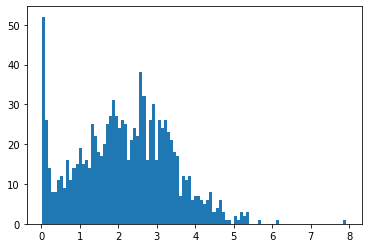

In [65]:
plt.hist(mem_bulk_exp_dict.values(), bins = 100)

52360


/scg/apps/software/jupyter/python_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


330


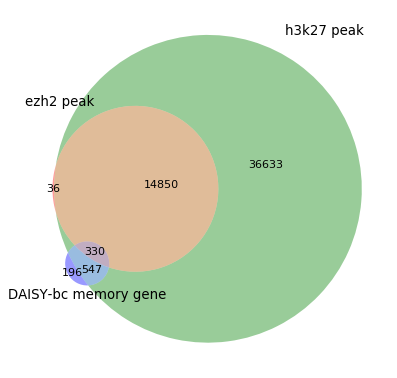

In [6]:
# visualize overlap using venn diagram

import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.pyplot import figure


def venn(ezh2, h3k27, mem):
    
    ezh2_set = set(ezh2["gene_name"])

    h3k27_set = set(h3k27["gene_name"])
    print(len(h3k27_set))
    h3k27["gene_name"].to_csv("/labs/congle/PRT/a375_mem_chipseq/4_macs2/macs2_p0.001/annotations/h3k27_gene_names.csv")
    mem_set = set(mem)
    
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    
    v = venn3(subsets = (ezh2_set, h3k27_set, mem_set), set_labels = ("ezh2 peak", "h3k27 peak", "DAISY-bc memory gene"))
    #plt.savefig("/labs/congle/PRT/a375_mem_chipseq/4_macs2/macs2_p0.001/plots/20201124_venn_diagram.pdf")
    
    intrsct = ezh2_set.intersection(h3k27_set).intersection(mem_set)
    print(len(intrsct))
    
    return intrsct
    
venn_1 = venn(ezh2_in, h3k27_in, mem_genes) 

{'UNC13A', 'CCDC171', 'ZNF250', 'SNTA1', 'NAPB', 'KIAA1841', 'CBX8', 'TTC7B', 'ESPN', 'CLIP2', 'ZNF287', 'ITPKC', 'ACAP1', 'C17orf53', 'NT5M', 'MBTD1', 'MAP3K6', 'KCTD11', 'MICAL1', 'DEPDC7', 'NFIL3', 'ZBTB21', 'PPP1R14C', 'GLIPR2', 'PPP1R13B', 'NRBP2', 'ZHX1-C8orf76', 'MTUS1', 'ZBTB49', 'KSR1', 'FAM102A'}


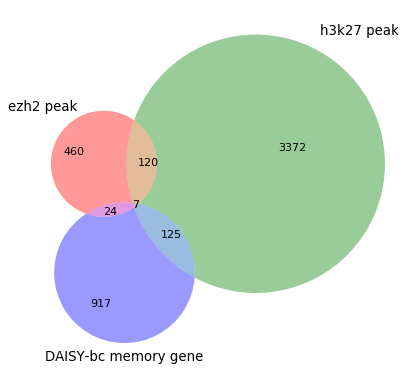

In [29]:
# where are these peaks -- subset based upon annotation and thne observe overlap

# visualize overlap using venn diagram

import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.pyplot import figure


def venn(ezh2, h3k27, mem, title, subset, subset2):
    
    ezh2_sub = ezh2[ezh2["type"].isin(subset)]
    ezh2_sub_2 = ezh2_sub[ezh2_sub["source"].isin(subset2)]
    h3k27_sub = h3k27[h3k27["type"].isin(subset)]
    h3k27_sub_2 = h3k27_sub[h3k27_sub["source"].isin(subset2)]
    #print(h3k27_sub)

    ezh2_set = set(ezh2_sub_2["gene_name"])
    #print(ezh2_set)
    h3k27_set = set(h3k27_sub_2["gene_name"])
    #print(h3k27_set)
    
    mem_set = set(mem)
    
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    
    v = venn3(subsets = (ezh2_set, h3k27_set, mem_set), set_labels = ("ezh2 peak", "h3k27 peak", "DAISY-bc memory gene"))
    #plt.savefig("/labs/congle/PRT/a375_mem_chipseq/4_macs2/macs2_p0.001/plots/20201124" + title, bbox_inches = "tight")
    
    intrsct = ezh2_set.intersection(h3k27_set).intersection(mem_set)
    ezh2_intrsct = ezh2_set.intersection(mem_set)
    print(ezh2_intrsct)
    
    return intrsct
    

venn_2 = venn(ezh2_in, h3k27_in, mem_genes, "_promoter_region.pdf", ["Promoter_internal", "Promoter_R", "Promoter_L"], ["protein_coding"]) 

In [35]:
print(venn_1)
print(venn_2)

import csv

with open("/labs/congle/PRT/a375_mem_chipseq/4_macs2/macs2_p0.001/annotations/ezh2_mem_h3k27_genes.csv", "w") as f:
    
    write = csv.writer(f)
    
    for gene in list(venn_1):
        
        write.writerow([gene])

{'NLRC5', 'MAPK8IP1', 'IQSEC1', 'ZNF160', 'ZBTB26', 'HOXB13', 'LINC01355', 'GMIP', 'SOX9', 'LMF2', 'CCDC61', 'KIAA1522', 'ZBTB3', 'NR2F1', 'ZNF516', 'CCR10', 'P2RY11', 'NEURL4', 'MC1R', 'FAM102A', 'EFNB3', 'ACCS', 'STAP2', 'FUCA1', 'PAX3', 'ZBTB21', 'C17orf53', 'PDIK1L', 'TMEM238', 'TBCEL', 'RNF144A', 'CLIP2', 'PIP4K2C', 'FAM72A', 'SLC17A9', 'SNTA1', 'FLT3LG', 'ABCC4', 'IQCC', 'FAM229A', 'MAST3', 'SPTB', 'DPF1', 'ROPN1', 'KCNN3', 'TRAF2', 'RHBDL1', 'KCTD21-AS1', 'RAB3D', 'ZNF696', 'SLC27A3', 'ZFP69B', 'RAB40C', 'HS3ST3A1', 'B4GALNT4', 'FAM110A', 'ZNF646', 'SPEG', 'SGSH', 'RAB11FIP5', 'FBXL19', 'EHF', 'CLCN2', 'NT5M', 'CCDC122', 'DCLRE1B', 'KIFC2', 'ZNF710', 'ZNF213', 'KCNAB2', 'AC007040.2', 'UNC13A', 'DOCK6', 'MAPK8IP3', 'ZHX1-C8orf76', 'TMEM184B', 'LBX2', 'SWT1', 'ZNF473', 'KIAA1324', 'RGS14', 'DOCK9', 'DENND3', 'IDUA', 'SIRT3', 'OSBPL7', 'BRPF1', 'GLT8D2', 'LAT2', 'NFATC4', 'NFIL3', 'SUSD1', 'SLC45A3', 'CABLES2', 'MAP3K6', 'ENO3', 'PAM16', 'C20orf194', 'FICD', 'NOP9', 'EIF2AK3', 'IRF

null dist has mean: 4.6985
null dist has mean: 1.4243
null dist has mean: 0.0


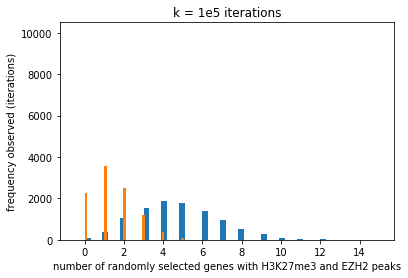

In [39]:
# is the 333 gene intrsction significant? Randomly choose 1072 genes and compute their intrsction lengths

import gzip
import random
import numpy as np

def rand_smpl(ezh2, h3k27, ref_genes, iterations, subset1, subset2):
    

    #gene_lst = list(set(pd.read_csv(all_genes, index_col = 0, header = None).index))
    #print(gene_lst)
    
    clean_lst = []
    
    for gene in ref_genes:
        #print(gene)
        gene_cln = gene.split(" ")[0]
        #print(gene_cln)
        clean_lst.append(gene_cln)
        

    ezh2_sub = ezh2[ezh2["type"].isin(subset1)]
    ezh2_sub_2 = ezh2_sub[ezh2_sub["source"].isin(subset2)]
    h3k27_sub = h3k27[h3k27["type"].isin(subset1)]
    h3k27_sub_2 = h3k27_sub[h3k27_sub["source"].isin(subset2)]
    
    ezh2_set = set(ezh2_sub_2["gene_name"])
    #print(ezh2_set)
    h3k27_set = set(h3k27_sub_2["gene_name"])
    
    
    
    rand_intrsct_lst = []
    
    for i in iterations:
        
        #print(len(gene_lst))
        rand = random.choices(clean_lst, k = 1072) 
        rand_set = set(rand)
        intrsct = ezh2_set.intersection(h3k27_set).intersection(rand_set)
        intrsct_area = len(intrsct)
        rand_intrsct_lst.append(intrsct_area)
    
    mean_olap = np.mean(rand_intrsct_lst)
    print("null dist has mean: " + str(mean_olap))
    plt.hist(rand_intrsct_lst, bins = 50)
    #plt.xlim(150, 350)
    plt.xlabel("number of randomly selected genes with H3K27me3 and EZH2 peaks")
    plt.ylabel("frequency observed (iterations)")
    plt.title("k = 1e5 iterations")
    #plt.savefig("/labs/congle/PRT/a375_mem_chipseq/4_macs2/macs2_p0.001/plots/null_peak_overlap_dist_20210114_exp_binning.pdf", bbox_inches = "tight")
         
#rand_1 = rand_smpl(ezh2_in, h3k27_in, "/oak/stanford/scg/lab_congle/PRT/20200729_10x_scaleup/mcpf1_v4/outs/filtered_feature_bc_matrix/all_genes.csv", 
#                  range(0, 10000))

rand_high = rand_smpl(ezh2_in, h3k27_in, high_genes, 
                  range(0, 10000), ["Promoter_internal", "Promoter_R", "Promoter_L"], ["protein_coding"])

rand_med = rand_smpl(ezh2_in, h3k27_in, med_genes, 
                  range(0, 10000), ["Promoter_internal", "Promoter_R", "Promoter_L"], ["protein_coding"])

rand_low = rand_smpl(ezh2_in, h3k27_in, low_genes, 
                  range(0, 10000), ["Promoter_internal", "Promoter_R", "Promoter_L"], ["protein_coding"])
    
    